##### Mole Classifier Kernel
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

The dataset is taken from the ISIC (International Skin Image Collaboration) Archive. It consists of 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The pictures have all been resized to low resolution (224x224x3) RGB. The task of this kernel is to create a model, which can classify a mole visually into benign and malignant.

As the dataset is pretty balanced, the model will be tested on the accuracy score, thus (TP + TN)/(ALL).

It has 2 different classes of skin cancer which are listed below :<br>
**1. Benign <br>**
**2. Malignant <br>**

In this kernel I will try to detect 2 different classes of moles using Convolution Neural Network with keras tensorflow in backend and then analyse the result to see how the model can be useful in practical scenario.<br>

In this kernel I have followed following 14 steps for model building and evaluation which are as follows : <br>
**Step 1 : Importing Essential Libraries**<br>
**Step 2: Loading pictures and making Dictionary of images and labels** <br>
**Step 3: Categorical Labels** <br>
**Step 4: Normalization** <br>
**Step 5: Train and Test Split** <br>
**Step 6: Model Building **<br>
**Step 7: Cross-validating model**<br>
**Step 8: Testing model**<br>
**Step 9: ResNet50** <br>

# Step 1 : importing Essential Libraries

In [1]:
!pip install scikeras
# Import KerasClassifier from scikeras.wrappers instead of keras.wrappers.scikit_learn
from scikeras.wrappers import KerasClassifier # Import KerasClassifier from scikeras.wrappers

# Rest of the imports
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from tensorflow.keras.utils import to_categorical# used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization # Import BatchNormalization from keras.layers
from keras import backend as K
#from keras.layers.normalization import BatchNormalization # This line is no longer needed
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding #This line is no longer needed, as to_categorical is already imported from tensorflow.keras.utils
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2 : Loading pictures and making Dictionary of images and labels
In this step I load in the pictures and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 224x224, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

In [3]:
folder_benign_train = '/content/drive/MyDrive/Skin Cancer Detection/Cancer Data/train/No Cancer'
folder_malignant_train = '/content/drive/MyDrive/Skin Cancer Detection/Cancer Data/train/Cancer'

folder_benign_test = '/content/drive/MyDrive/Skin Cancer Detection/Cancer Data/test/No Cancer'
folder_malignant_test = '/content/drive/MyDrive/Skin Cancer Detection/Cancer Data/test/Cancer'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Define a function to resize images
def resize_image(image, target_size=(224, 224)):
    """Resizes an image to the target size using PIL.

    Args:
        image: The PIL Image object to resize.
        target_size: A tuple (width, height) representing the desired size.

    Returns:
        The resized PIL Image object.
    """
    return image.resize(target_size)

# Load and resize training images
ims_benign = [np.asarray(resize_image(Image.open(os.path.join(folder_benign_train, filename)).convert("RGB"))) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [np.asarray(resize_image(Image.open(os.path.join(folder_malignant_train, filename)).convert("RGB"))) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load and resize testing images
ims_benign = [np.asarray(resize_image(Image.open(os.path.join(folder_benign_test, filename)).convert("RGB"))) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [np.asarray(resize_image(Image.open(os.path.join(folder_malignant_test, filename)).convert("RGB"))) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

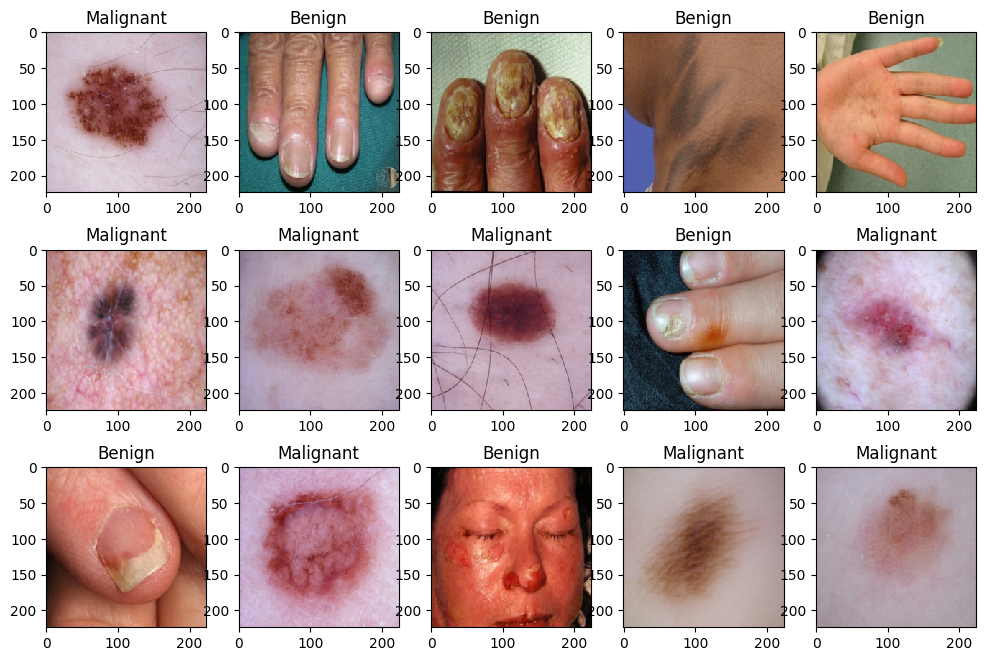

In [4]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Step 3: Categorical Labels
Turn labels into one hot encoding

In [5]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Step 4 : Normalization
Normalize all Values of the pictures by dividing all the RGB values by 255

In [6]:
# With data augmentation to prevent overfitting
X_train = X_train/255.
X_test = X_test/255.

# Step 5: Model Building
## CNN
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 64 filters for the two firsts conv2D layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in one fully-connected (Dense) layer which is just artificial an neural networks (ANN) classifier.

In [7]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)



In [8]:
# ipython-input-23-f5591b885e9e
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr) # Changed lr to learning_rate
    else:
        optimizer = Adam(learning_rate=lr) # Changed lr to learning_rate

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 41: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


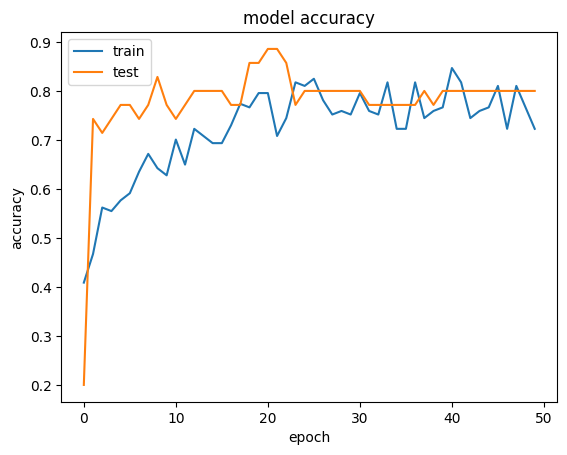

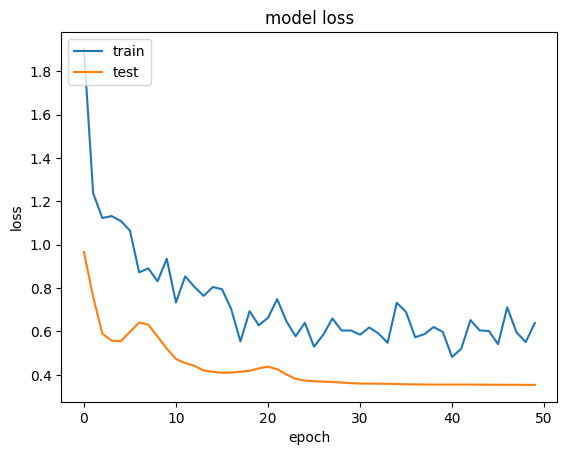

In [9]:
# ipython-input-25-f5591b885e9e
import matplotlib.pyplot as plt # Make sure matplotlib.pyplot is imported
import tensorflow as tf  # Import TensorFlow
#from tensorflow import keras  # Explicitly import keras from TensorFlow #This import is no longer needed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau # Import ReduceLROnPlateau

input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

# Remove the @tf.function decorator
#def build_and_compile_model(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
#          init= 'normal', activ= 'relu', optim= 'adam'):
def build_and_compile_model(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    # Define optimizer inside the function
    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr) # Changed lr to learning_rate
    else:
        optimizer = Adam(learning_rate=lr) # Changed lr to learning_rate

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', # Changed 'val_acc' to 'val_accuracy'
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

# Create and compile the model
model = build_and_compile_model(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

# Convert X_train and y_train to TensorFlow tensors
#X_train = tf.convert_to_tensor(X_train) #This conversion is not needed here as the model.fit call handles it
#y_train = tf.convert_to_tensor(y_train) #This conversion is not needed here as the model.fit call handles it

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0,
                    callbacks=[learning_rate_reduction]
                   )
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy']) # Use 'accuracy' instead of 'acc'
plt.plot(history.history['val_accuracy']) # Use 'val_accuracy' instead of 'val_acc'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
K.clear_session()
del model
del history

# Step 6: Cross-Validating Model


In [12]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr,
                  init= init,
                  activ= activ,
                  optim=optim,
                  input_shape= input_shape)

    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 89.66%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 89.47%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 84.21%
87.78% (+/- 2.52%)


# Step 7: Testing the model

First the model has to be fitted with all the data, such that no data is left out.

In [13]:
# Fitting model to all data
model = build(lr=lr,
              init= init,
              activ= activ,
              optim=optim,
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict(X_test)  # Get prediction probabilities
y_pred = np.argmax(y_pred, axis=1)  # Get the class with highest probability

print(accuracy_score(np.argmax(y_test, axis=1), y_pred)) # Print the accuracy

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
0.87


In [14]:
# ipython-input-12-8df782fe452f
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
    # create model
    model = build(lr=lr,
                  init=init,
                  activ=activ,
                  optim=optim,
                  input_shape=input_shape)

    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    cvscores.append(scores[1] * 100)
    # Removed: K.clear_session()  #Keep the model in memory for saving later
    # Removed: del model       #Keep the model in memory for saving later

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# ipython-input-0-8df782fe452f
# Fitting model to all data
model = build(lr=lr,
              init=init,
              activ=activ,
              optim=optim,
              input_shape=input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size=batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
          )

# Testing model on test data to evaluate
y_pred = model.predict(X_test)  # Get prediction probabilities
y_pred = np.argmax(y_pred, axis=1)  # Get the class with highest probability

print(accuracy_score(np.argmax(y_test, axis=1), y_pred))  # Print the accuracy


# ipython-input-13-8df782fe452f
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.weights.h5")  # Changed filename to model.weights.h5
print("Saved model to disk")

# Clear memory, because of memory overload
del model  # Now it's safe to delete the model
K.clear_session()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 89.66%


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 82.46%


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 80.70%
84.27% (+/- 3.87%)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
0.86
Saved model to disk


# Step 8: ResNet50
The CNN above is not a very sophisticated model, thus the resnet50, is also tried

Epoch 1/100
5/5 - 92s - 18s/step - accuracy: 0.6715 - loss: 0.6268 - val_accuracy: 0.2857 - val_loss: 0.6945 - learning_rate: 1.0000e-05
Epoch 2/100
5/5 - 26s - 5s/step - accuracy: 0.7153 - loss: 0.5265 - val_accuracy: 0.7143 - val_loss: 0.6876 - learning_rate: 1.0000e-05
Epoch 3/100
5/5 - 1s - 295ms/step - accuracy: 0.7445 - loss: 0.4974 - val_accuracy: 0.7143 - val_loss: 0.6765 - learning_rate: 1.0000e-05
Epoch 4/100
5/5 - 3s - 510ms/step - accuracy: 0.7883 - loss: 0.4468 - val_accuracy: 0.7143 - val_loss: 0.6653 - learning_rate: 1.0000e-05
Epoch 5/100
5/5 - 2s - 300ms/step - accuracy: 0.8613 - loss: 0.3895 - val_accuracy: 0.7143 - val_loss: 0.6555 - learning_rate: 1.0000e-05
Epoch 6/100
5/5 - 3s - 507ms/step - accuracy: 0.8978 - loss: 0.3326 - val_accuracy: 0.7143 - val_loss: 0.6466 - learning_rate: 1.0000e-05
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
5/5 - 2s - 305ms/step - accuracy: 0.8686 - loss: 0.3316 - val_accuracy: 0.7143 - val_l

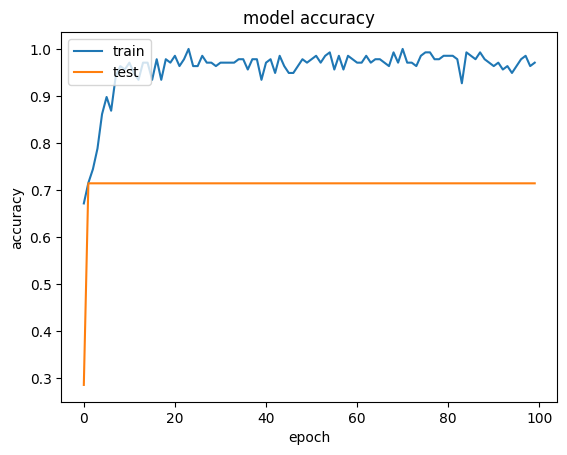

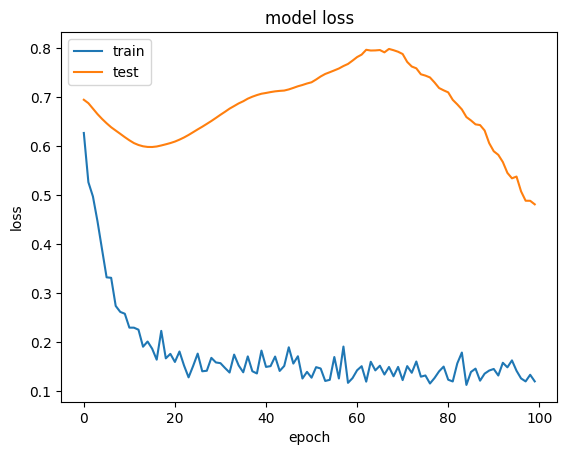

In [15]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 100  # Increase the number of epochs
batch_size = 32 # Decrease batch size, allows more updates per epoch

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(learning_rate=lr) ,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2,
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy']) # Changed 'acc' to 'accuracy'
plt.plot(history.history['val_accuracy']) # Changed 'val_acc' to 'val_accuracy'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Create data generators (unchanged)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Prepare NumPy arrays from the generators
X_train_augmented = []
y_train_augmented = []
for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    X_train_augmented.extend(batch_x)
    y_train_augmented.extend(batch_y)

X_val_augmented = []
y_val_augmented = []
for i in range(len(val_generator)):
    batch_x, batch_y = val_generator[i]
    X_val_augmented.extend(batch_x)
    y_val_augmented.extend(batch_y)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
X_val_augmented = np.array(X_val_augmented)
y_val_augmented = np.array(y_val_augmented)

# Learning rate scheduler (unchanged)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=1e-7
)

# Fit the model using NumPy arrays
history = model.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=epochs,
    validation_data=(X_val_augmented, y_val_augmented),
    verbose=0,
    callbacks=[learning_rate_reduction]
)

In [19]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)

# serialize weights to HDF5
model.save_weights("resnet50.weights.h5")  # Changed filename to resnet50.weights.h5
print("Saved model to disk")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
0.5
Saved model to disk
